# Running patch dynamics in the restricted path integral (RPI) approach

In this tutorial, we conduct patch dynamics calculations for the restricted path integral (RPI) approach. A patch refers to a time segment of the total time duration for an NBRA trajectory. In RPI, the electronic dynamics of each patch — patch dynamics — are eventually summed to yield the overall population dynamics (see `20_step5_sum_rpi/` for this patch summation). The patch dynamics is governed by the coherent Ehrenfest propagation and needs to be conducted repetitively, wherein the initial state is set to each of the pure states. The population from each patch dynamics serves as a transition probability from a given intial state.

The RPI calculations presented in `19_step4_patch_rpi/` (this tutorial) and `20_step5_sum_rpi/` can be considered a further reduction of the conventional step4 NBRA-TSH dynamics calculations (examples can be found in `5_step4/`, `9_step4/`, and `15_step4_bllz/`), as the electronic dynamics is simplified by tracking only electronic populations. Thus, for this tutorial, the NBRA procedures from step 1 to step 3 — predefining a nuclear trajectory and computing electronic properties such as molecular overlap, time overlap and nonadiabatic coupling between a given electronic basis — needs to be done first.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
   
2. [Overview of required files](#2)

3. [Run the patch dynamics](#3)

## A. Learning objectives
* To be able to run the patch dynamics for the population dynamics in the restricted path integral approach

## B. Use cases

* [Run NAMD simulations](#run_namd)
* [Plot results](#plot_res)

## C. Functions
- `libra_py`
  - `workflow`
    - `nbra`
      - `rpi`
        - [`generic_patch_dyn`](#run_namd)
        - [`run_patch_dyn_serial`](#run_namd)
  - `dynamics`
    - `tsh`
      - `plot`
        - [`plot_dynamics`](#plot_res)
  - `units`
    - [`fs2au`](#run_namd)

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

First, let's import all necessary libraries and define parameters such as colors

In [25]:
import os
import matplotlib.pyplot as plt   # plots
import numpy as np
import scipy.sparse as sp
import h5py
import warnings
import json
import pickle

from liblibra_core import *
import util.libutil as comn
from libra_py import units, data_conv
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot

from libra_py.workflows.nbra import rpi

#from matplotlib.mlab import griddata
%matplotlib inline 
#warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13", "23", "14", "24"]

## 2. Overview of required files<a name="2"></a>
[Back to TOC](#toc)

A template file for running a patch dynamics.

* `submit_template.slm`

The path of the vibronic Hamiltonian files. In this example, we use the energies and nonadiabatic couplings (NACs) between the many-body (MB) basis for the Rutile TiO2 system.

* `../8_step3/1_DFT/res-mb-sd-DFT`

## 3. Setting the patch dynamics
[Back to TOC](#toc)

We need to set parameters - about dynamics control, electron and nuclear initialization - for patch dynamics. 

Since the RPI method is based on the NBRA, we'll just read the vibronic Hamiltonian and time overlap from `../8_step3/1_DFT/res-mb-sd-DFT` to build our `model_params`. By adjusting `istep` and `fstep` below, we set the range of data to read.

In [26]:
istep = 1200
fstep = 1301

path_to_save_Hvibs = os.getcwd() + '/../8_step3/1_DFT/res-mb-sd-DFT'
basis_type = 'ci'
nstates = 11

model_params = {"timestep":0, "icond":0,  "model0":0, "nstates":nstates}

E = []
for step in range(istep, fstep):
    energy_filename = F"{path_to_save_Hvibs}/Hvib_{basis_type}_{step}_re.npz"
    energy_mat = sp.load_npz(energy_filename)
    E.append( np.array( np.diag( energy_mat.todense() ) ) )
E = np.array(E)

St = []
for step in range(istep, fstep):
    St_filename = F"{path_to_save_Hvibs}/St_{basis_type}_{step}_re.npz"
    St_mat = sp.load_npz(St_filename)
    St.append( np.array( St_mat.todense() ) )
St = np.array(St)

NAC = []
Hvib = []
for c, step in enumerate(range(istep, fstep)):
    nac_filename = F"{path_to_save_Hvibs}/Hvib_{basis_type}_{step}_im.npz"
    nac_mat = sp.load_npz(nac_filename)
    NAC.append( np.array( nac_mat.todense() ) )
    Hvib.append( np.diag(E[c, :])*(1.0+1j*0.0)  - (0.0+1j)*nac_mat[:, :] )

NAC = np.array(NAC)
Hvib = np.array(Hvib)

model_params.update({"E": E, "St": St, "NAC": NAC, "Hvib": Hvib})

Then we set the control parameter of patch dynamics - coherent Ehrenfest propagation.

In [27]:
# Setting the coherent Ehrenfest propagation. Define the argument-dependent part first.
dyn_general = {"nstates":nstates, "which_adi_states":range(nstates), "which_dia_states":range(nstates)}

dyn_general.update({"ntraj":1, "mem_output_level":2, "progress_frequency":1,  
                    "properties_to_save":["timestep", "time", "se_pop_adi"], "prefix":"./", "isNBRA": 0,
                    "ham_update_method":2, "ham_transform_method":0, "time_overlap_method":0, "nac_update_method":0,
                    "hvib_update_method":0, "force_method":0, "rep_force":1, "hop_acceptance_algo":0, "momenta_rescaling_algo":0, 
                    "rep_tdse":1, "electronic_integrator":2, "tsh_method":-1, "decoherence_algo":-1, "decoherence_times_type":-1, 
                    "do_ssy":0, "dephasing_informed":0})

# Explicitly set some defaults (or reasonable value!), to suppress warnings
dyn_general.update({"rep_sh":1, "rep_lz":0, "rep_ham":0, "enforce_state_following":0, "direct_init": 0,
                    "enforced_state_indxed":0, "do_phase_correction":0, "phase_correction_tol":1e-10,
                    "max_number_attempts":10,  "total_energy":0.01, "tcnbra_nu_therm":0.01,
                    "thermally_corrected_nbra":0, "tcnbra_nhc_size":1, "tcnbra_do_nac_scaling":1, 
                    "use_Jasper_Truhlar_criterion":1, "fssh2_revision": 0, 
                    "fssh3_size_option":0, "fssh3_approach_option":0, "fssh3_decomp_option":0, 
                    "fssh3_dt": 0.001, "fssh3_max_steps": 1000, "fssh3_err_tol": 1e-7,
                    "decoherence_C_param":0.1, "decoherence_eps_param":1.0, 
                    "MK_alpha": 0.0, "MK_verbosity":0, "sdm_norm_tolerance":1e-4,
                    "use_xf_force":0, "project_out_aux":0, "use_td_width": 0, "coherence_threshold": 0.01,
                    "entanglement_opt": 0, "ETHD3_alpha":0.01, "ETHD3_beta":0.01, "Temperature":300.0
                   })

Then we initialize electron and nuclear degrees of freedom. The `elec_params["istate"]` below will be controlled inside Libra to consider multiple initial conditions from `0` to `nstates - 1`.

In [28]:
# Electronic DOF
elec_params = {"ndia":nstates, "nadi":nstates, "verbosity":-1, "init_dm_type":0, "init_type":1, "rep":1,"istate":0}

# Nuclear DOF - these parameters don't matter much in the NBRA calculations
nucl_params = {"ndof":1, "init_type":3, "q":[-10.0], "p":[0.0], "mass":[2000.0], "force_constant":[0.01], "verbosity":-1,
               "q_width": [1.0], "p_width": [1.0]}

## 4. Running the patch dynamics<a name="3"></a>
[Back to TOC](#toc)

Based on the patch dynamics setting above, the function `rpi.generic_patch_dyn` runs the dynamics over initial gemetry conditions, patches and initial states. The above parameters - `dyn_params`, `compute_model`, `model_params`, `nucl_params` and `elec_params` - are taken as the argument. 

Also, the control parameter of RPI patch dynamics, `rpi_params` are is:

***When you submit jobs to a cluster***

* `run_slurm`: Whether to use the slurm environment to submit the jobs using the `submit_template` file. If it is set to `False`, it will run the calculations on the active session but multiple jobs will be run on the current active session. 

* `submit_template`: The path of a template slurm submit file.

* `submission_exe`: The submission executable

* `run_python_file`: The path of a template running script.

* `python_exe`: The Python executable

***RPI dynamics settings***

* `nsteps`: The total number of RPI simulation steps

* `iconds`: The list of initial geometry indices of the trajectory segment used for setting `model_params`. Each initial condition in this list characterizes each batch.

* `npatches`: The number of patches. The time duration of each patch dynamics will be `int(nsteps/npatches) + 1`. The additional single step is because the tsh recipe (see `libra_py.dynamics.tsh.compute` for details) used for the patch dynamics saves the dynamics information before the electron-nuclear propagation in each MD loop.

* `nstates`: The number of electronic states.

* `dt`: the time step in the atomic unit.

* `prefix`: The prefix of directories having the output patch dynamics. The patch dynamics data are characterized by three numbers - the batch index, the patch index, the initial state index. Thus, the full name of output directory is expressed by these three numbers and their limits as follows.

  `rpi_params["prefix"] + F"n{len(rpi_params["iconds"])}_ibatch{X}" +`        `F"_n{rpi_params["npatches"]}_ipatch{Y}" + F"_n{rpi_params["nstates"]}_istate{Z}"`
  
  Here, X, Y and Z runs:
  
  X = `0` to `len(rpi_params["iconds"]) - 1`
  
  Y = `0` to `rpi_params["npatches"] - 1` 
  
  Z = `0` to `rpi_params["nstates"] - 1`
  
  An NBRA trajectory from an initial geometry defined in rpi_params['iconds'] is called a batch.

Note that

* The following routine will submit `len(iconds) * npatches * nstates` jobs or serially run that amount of patch dynamics through a loop.

* The number of f needs to be equal to or greater than `max(iconds) + nsteps + 1` to cover the electronic information for patch dynamics.

* Technically, `nsteps` does not have to be divisible by `npatches`. However, if `nsteps` is not divisible by `npatches`, the electronic propagation in the last time segment — that is, from `int(nsteps / npatches) * npatches` to `nsteps` — will be discarded in the final patch summation, in `20_step5_sum_rpi/`. 

### 4.1 Serial calculations
Serial calculations are down with the following parametrization, where `rpi_params['run_slurm'] = False`. We set the interface function to set the NBRA Hamiltonian here.

In [29]:
class tmp:
    pass

def compute_model(q, params, full_id):
    """
    This function serves as an interface function for a serial patch dynamics calculation.
    """

    timestep = params["timestep"]
    nst = params["nstates"]
    E = params["E"]
    NAC = params["NAC"]
    Hvib = params["Hvib"]
    St = params["St"]

    obj = tmp()

    obj.ham_adi = data_conv.nparray2CMATRIX( np.diag(E[timestep, : ]) )
    obj.nac_adi = data_conv.nparray2CMATRIX( NAC[timestep, :, :] )
    obj.hvib_adi = data_conv.nparray2CMATRIX( Hvib[timestep, :, :] )
    obj.basis_transform = CMATRIX(nst,nst); obj.basis_transform.identity()  #basis_transform
    obj.time_overlap_adi = data_conv.nparray2CMATRIX( St[timestep, :, :] )

    return obj

In [ ]:
rpi_params = {'run_slurm': False, 'submit_template': 'submit_template.slm', 'submission_exe': 'sbatch', 
              'run_python_file': 'run_template.py', 'python_exe': 'python',
              'path_to_save_Hvibs': os.getcwd() + '/../8_step3/1_DFT/res-mb-sd-DFT', 'basis_type': 'ci',  
              'nsteps': 50, 'iconds': [0, 25, 50], 'npatches': 2, 'nstates': 11, 'dt': 1.0*units.fs2au, 
              'prefix': 'out_'  
             }

# Set the patch dynamics duration and dt here.
dyn_params = dict(dyn_general)

rpi.generic_patch_dyn(rpi_params, dyn_params, compute_model, model_params, elec_params, nucl_params)

After the calculation, we can see the list of output patch dynamics results.

In [32]:
! ls -F

README.md
data.tar.bz2
out_n3_ibatch0_n2_ipatch0_n11_istate0/
out_n3_ibatch0_n2_ipatch0_n11_istate1/
out_n3_ibatch0_n2_ipatch0_n11_istate10/
out_n3_ibatch0_n2_ipatch0_n11_istate2/
out_n3_ibatch0_n2_ipatch0_n11_istate3/
out_n3_ibatch0_n2_ipatch0_n11_istate4/
out_n3_ibatch0_n2_ipatch0_n11_istate5/
out_n3_ibatch0_n2_ipatch0_n11_istate6/
out_n3_ibatch0_n2_ipatch0_n11_istate7/
out_n3_ibatch0_n2_ipatch0_n11_istate8/
out_n3_ibatch0_n2_ipatch0_n11_istate9/
out_n3_ibatch0_n2_ipatch1_n11_istate0/
out_n3_ibatch0_n2_ipatch1_n11_istate1/
out_n3_ibatch0_n2_ipatch1_n11_istate10/
out_n3_ibatch0_n2_ipatch1_n11_istate2/
out_n3_ibatch0_n2_ipatch1_n11_istate3/
out_n3_ibatch0_n2_ipatch1_n11_istate4/
out_n3_ibatch0_n2_ipatch1_n11_istate5/
out_n3_ibatch0_n2_ipatch1_n11_istate6/
out_n3_ibatch0_n2_ipatch1_n11_istate7/
out_n3_ibatch0_n2_ipatch1_n11_istate8/
out_n3_ibatch0_n2_ipatch1_n11_istate9/
out_n3_ibatch1_n2_ipatch0_n11_istate0/
out_n3_ibatch1_n2_ipatch0_n11_istate1/
out_n3_ibatch1_n2_ipatch0_n11_istate10/

### 4.2 Job submissions to a cluster
Since patch dynamics needs to be repetitively done over a range of initial geometries, patches and initial states, distributing all patch dynamics jobs to a cluster is efficient. We'll submit `len(rpi_params["iconds"]) * rpi_params["npatches"] * rpi_params["nstates"]` jobs.

For that purpose, we should save the parameter dictionaries for the patch dynamics - `dyn_params`, `model_params`, `elec_params` and `nucl_params` using the `pickle` package. The interface function `compute_model` is separately defined in our template running script, `rpi_params["run_python_file"]`.

In [14]:
dyn_params = dict(dyn_general)
with open('dyn_params.pkl', 'wb') as f:
    pickle.dump(dyn_params, f)

with open('model_params.pkl', 'wb') as f:
    pickle.dump(model_params, f)

with open('elec_params.pkl', 'wb') as f:
    pickle.dump(elec_params, f)

with open('nucl_params.pkl', 'wb') as f:
    pickle.dump(nucl_params, f)

In [ ]:
rpi_params = {'run_slurm': True, 'submit_template': 'submit_template.slm', 'submission_exe': 'sbatch', 
              'run_python_file': 'run_template.py', 'python_exe': 'python',
              'nsteps': 50, 'iconds': [0, 25, 50], 'npatches': 2, 'nstates': 11, 'dt': 1.0*units.fs2au, 
              'prefix': 'out_'  
             }

rpi.generic_patch_dyn(rpi_params, dyn_params, _, model_params, elec_params, nucl_params)

### 4.3 Patch dynamics with various npatches
Various `npatches` can be utilized. We can run a new set of patch dynamics with `npatches = 10`.  

In [34]:
rpi_params.update({'npatches': 10})

Then we can perform serial calculations or use a cluster.

In [ ]:
# For serial calculations
rpi.generic_patch_dyn(rpi_params, dyn_params, compute_model, model_params, elec_params, nucl_params)

# When jobs are distributed through a cluster, the interface function compute_model is separately defined in the running script.
#rpi.generic_patch_dyn(rpi_params, dyn_params, _, model_params, elec_params, nucl_params)

In the next section, we'll see that the time duration of the patch dynamics with `npatches = 10` is shortened to `int(nsteps/npatches) + 1 = 50/10 + 1`.

## 5. Plotting patch dynamics

The population in a patch can be visualized as follows. The patch dynamics employs the pure adiabatic initial conditions. Thus, we can see each patch dynamics directory contains the population dynamics with different initial states, as specified by `istate` below.

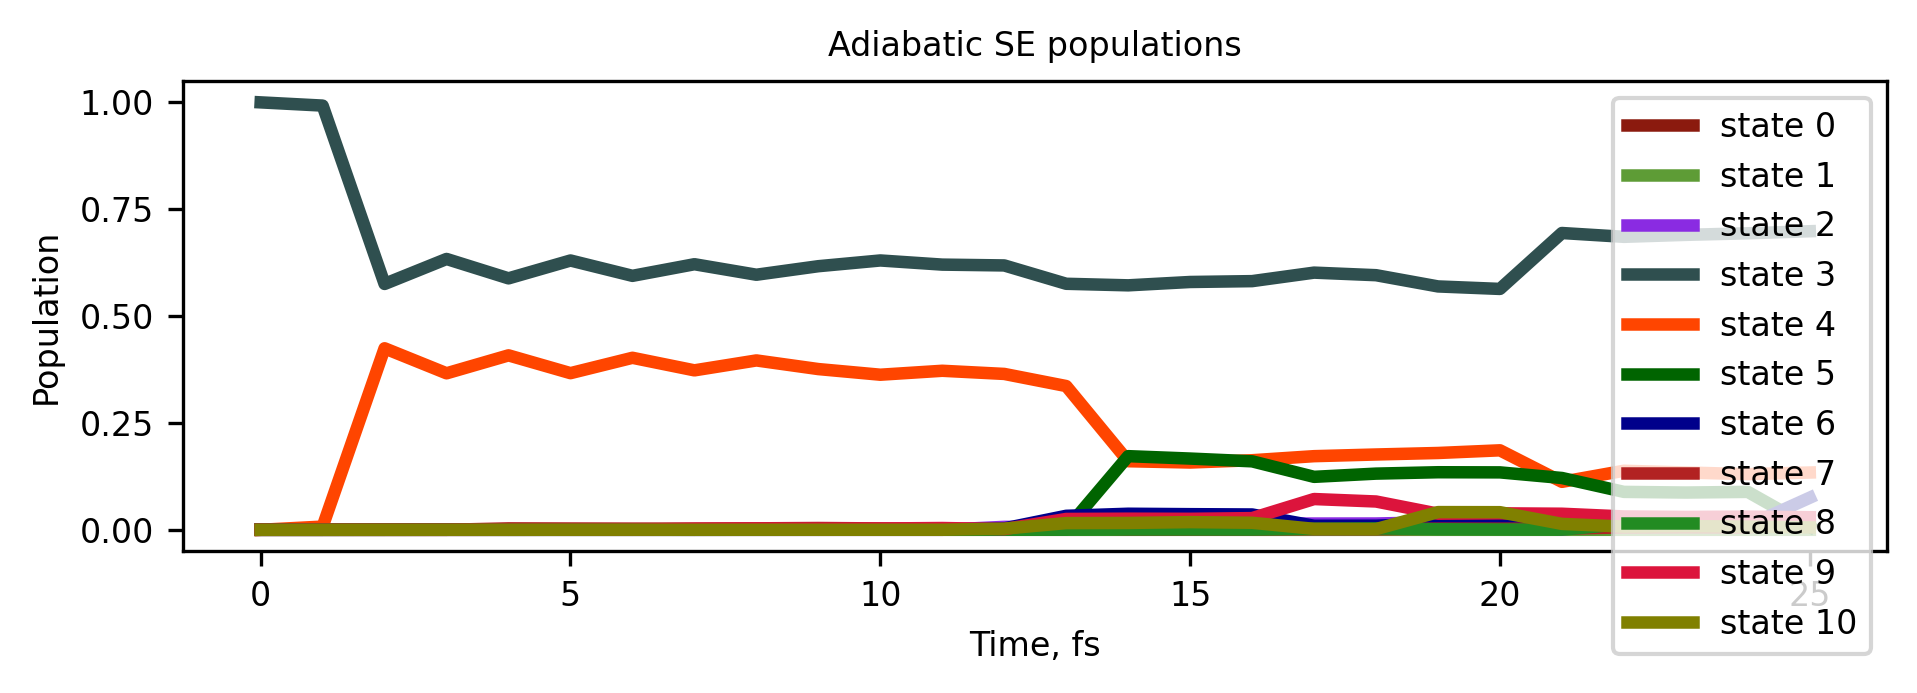

In [36]:
npatches = 2
nbatches = len(rpi_params["iconds"])
ibatch, ipatch, istate = 0, 0, 3

dir_patch = rpi_params['prefix'] + F"n{nbatches}_ibatch{ibatch}" + F"_n{npatches}_ipatch{ipatch}" \
  + F"_n{rpi_params['nstates']}_istate{istate}"

plot_params = { "prefix": dir_patch, "filename":"mem_data.hdf", "output_level":2,
                "which_trajectories":0, "which_dofs":[0], "which_adi_states":list(range(rpi_params["nstates"])), 
                "which_dia_states":list(range(rpi_params["nstates"])), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["se_pop_adi"], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":0, "do_show":1
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

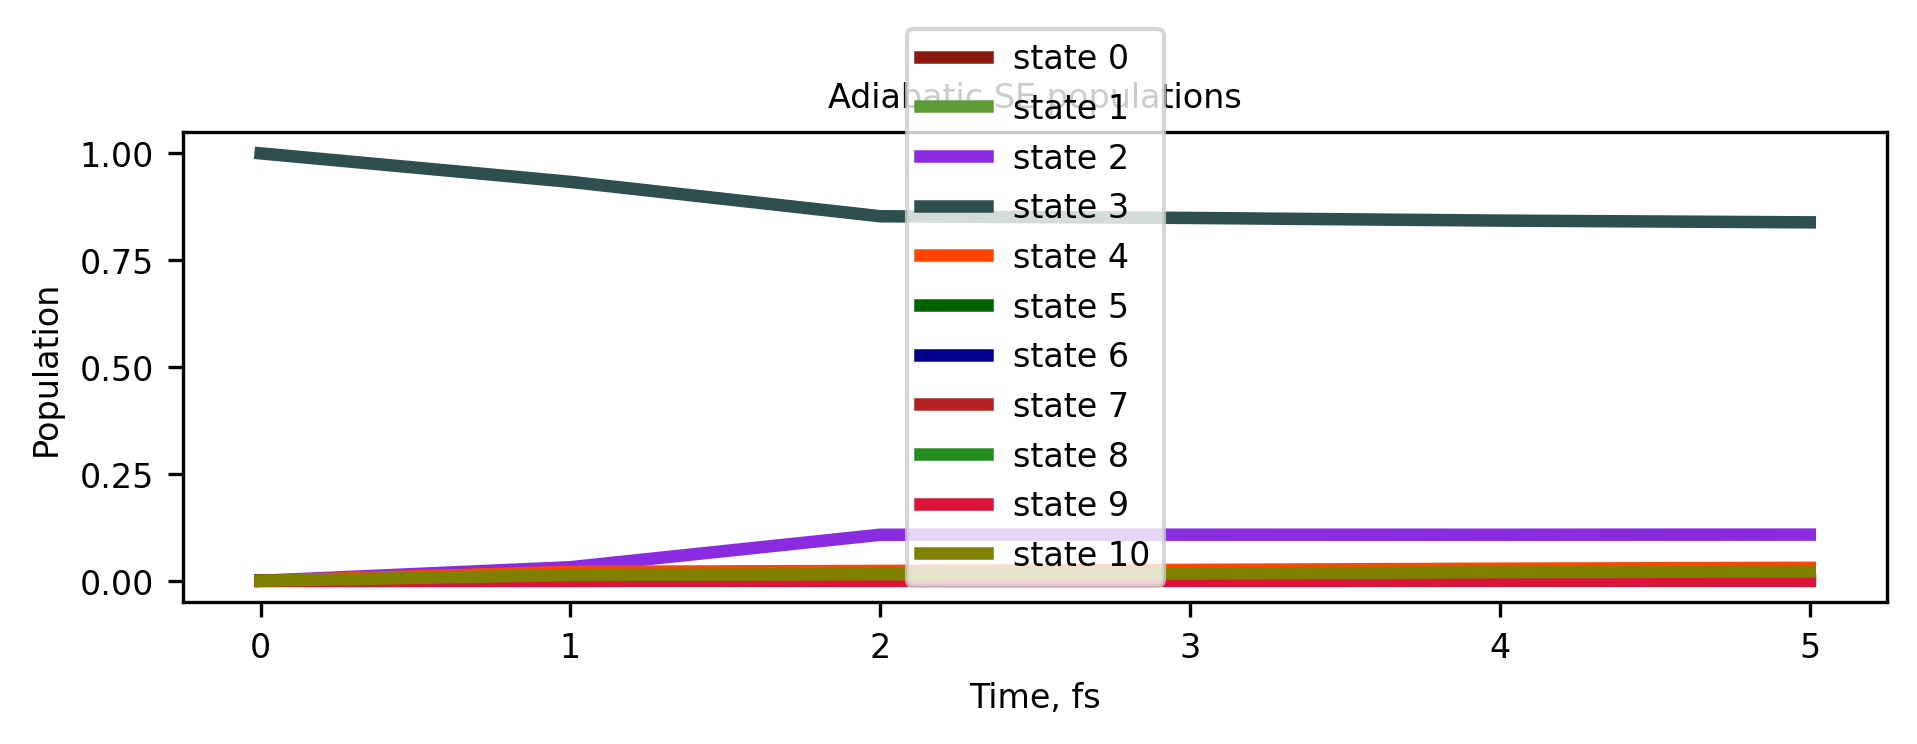

In [37]:
npatches = 10
nbatches = len(rpi_params["iconds"])
ibatch, ipatch, istate = 0, 4, 3

dir_patch = rpi_params['prefix'] + F"n{nbatches}_ibatch{ibatch}" + F"_n{npatches}_ipatch{ipatch}" \
  + F"_n{rpi_params['nstates']}_istate{istate}"

plot_params = { "prefix": dir_patch, "filename":"mem_data.hdf", "output_level":2,
                "which_trajectories":0, "which_dofs":[0], "which_adi_states":list(range(rpi_params["nstates"])), 
                "which_dia_states":list(range(rpi_params["nstates"])), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["se_pop_adi"], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":0, "do_show":1
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

Eventually, individual patch dynamics will be summed to yield the global population, as explained in `20_step5_sum_rpi/`

### Exercise 1
Check the patch dynamics by changing the set of `icond`, `ipatch`, `istate` values. Especially, note that how the initial state is altered with respect to `istate`.

### Exercise 2
Explore various numbers of patches.